 # **<u> Projet SIGMA M2 : TELEA** </u> 

### **Importation des bibliothèques nécessaire au projet**

In [9]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import numpy as np
sys.path.insert(0, "/home/onyxia/work/")
from my_function import rasterisation
from libsigma import read_and_write
#from libsigma.read_and_write import load_img_as_array
#from libsigma.read_and_write import write_image
#from libsigma.read_and_write import open_image
from libsigma import classification as cla

### **Importation des chemins d'accès**

In [2]:
ts_path = '/home/onyxia/work/data/projet_eval'
result_path = '/home/onyxia/work/projet_telea_MARTIN_AXEL/results/figure'
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")


### **Importation des échantillons disponibles de la zone d'étude / Analyse des échantillons disponibles** 

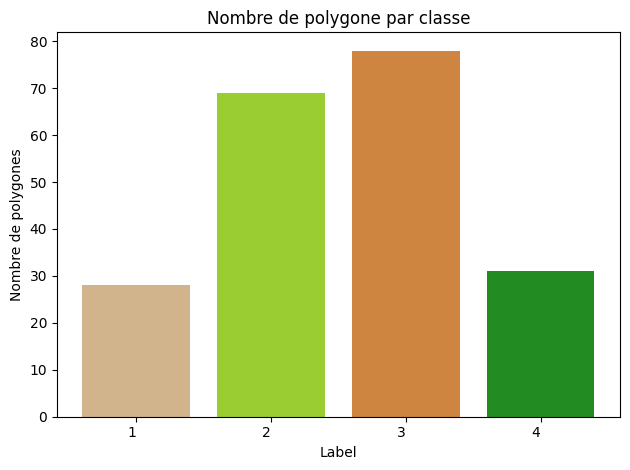

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


gdal_rasterize -at -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.
Comptage des pixels par classe :
Valeur 1 -> 132 pixels
Valeur 2 -> 313 pixels
Valeur 3 -> 364 pixels
Valeur 4 -> 141 pixels


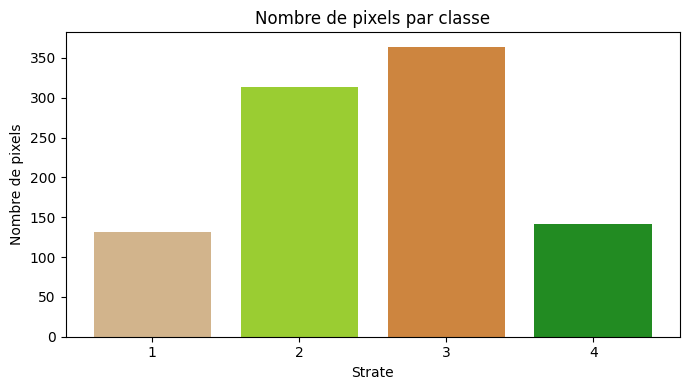

In [3]:
sample_data = gpd.read_file(in_vector)
sample_data.head
counts_label = sample_data.groupby("strate").size()

ref_raster = '/home/onyxia/work/data/projet_eval/pyrenees_23-24_B02.tif'
strat = "strate"
samples_raster = '/home/onyxia/work/results/samples_raster.tif'


colors = ["tan","yellowgreen", "peru", "forestgreen"]
plt.bar(counts_label.index.astype(str), counts_label.values, color=colors)
plt.title("Nombre de polygone par classe")
plt.xticks(ha="right")
plt.xlabel("Label")
plt.ylabel("Nombre de polygones")
plt.tight_layout()
plt.show()

rasterisation(in_vector, ref_image, samples_raster, strat, dtype="Int32")

arr3d = load_img_as_array(samples_raster, verbose=False)

arr = arr3d[:, :, 0]                                      # on prend la bande 1

# enlever le fond (0)
vals = arr[arr != 0]

values, counts = np.unique(vals, return_counts=True)

print("Comptage des pixels par classe :")
for v, c in zip(values, counts):
    print(f"Valeur {int(v)} -> {int(c)} pixels")

# --- 4) Barplot pixels par classe ---
plt.figure(figsize=(7,4))
plt.bar(values.astype(int).astype(str), counts, color=colors[:len(values)])
plt.title("Nombre de pixels par classe")
plt.xlabel("Strate")
plt.ylabel("Nombre de pixels")
plt.tight_layout()
plt.show()

### **Phénologie des strates, mise en évidence des landes (création du raster)**

In [10]:
import os
data_type_match = {'uint8': gdal.GDT_Byte,
                   'uint16': gdal.GDT_UInt16,
                   'uint32': gdal.GDT_UInt32,
                   'int16': gdal.GDT_Int16,
                   'int32': gdal.GDT_Int32,
                   'float32': gdal.GDT_Float32,
                   'float64': gdal.GDT_Float64}

# define parameters
dirname = '/home/onyxia/work/data/projet_eval'
out_dirname = '/home/onyxia/work/results'
dir_B3 = os.path.join(dirname, 'pyrenees_23-24_B03.tif')
dir_B5 =  os.path.join(dirname, 'pyrenees_23-24_B05.tif')
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')

# load data
data_set_B3 = open_image(dir_B3)
img_B3 = load_img_as_array(dir_B3)
data_set_B5 = open_image(dir_B5)
img_B5 = load_img_as_array(dir_B5)

# do some processingwith numpy: compute ndvi
B3 = img_B3[:,:,:].astype('float32')
B5 = img_B5[:,:,:].astype('float32')
ari = (1/B3)-(1/B5) / (1/B3)+(1/B5)

# write it
write_image(out_ari_filename, ari, data_set=data_set_B5,
            gdal_dtype=data_type_match['float32'], projection=None)

ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)  
band.FlushCache()
ds = None

## **Création du graphique**

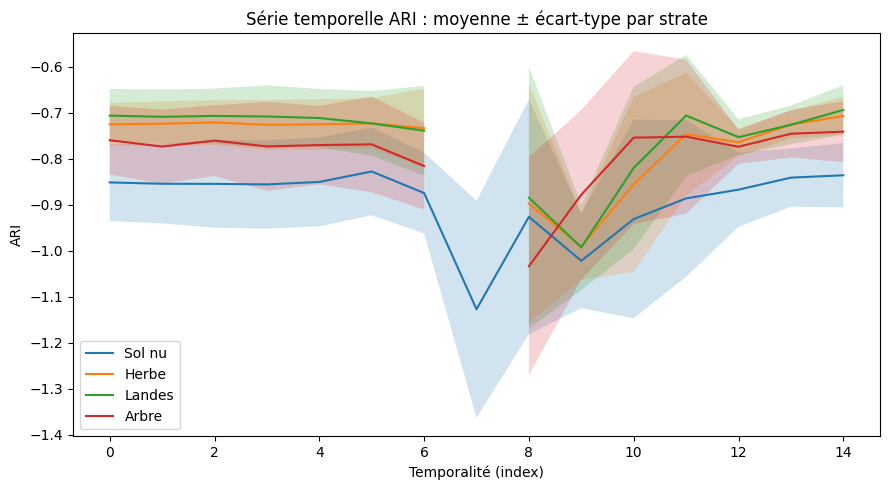

In [ ]:

# Extraction des pixels ARI par strate (ROI raster)
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,       # ton ARI multi-bandes (15 temporalités)
    samples_raster,         # raster des strates (1..4)
    output_fmt="by_label"
)

names = {1:"Sol nu", 2:"Herbe", 3:"Landes", 4:"Arbre"}

fig, ax = plt.subplots(figsize=(9, 5))

# axe x = temporalités (0..14)
n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

for lab in sorted(dict_X.keys()):   # lab = 1,2,3,4
    X = dict_X[lab]                 # (nb_pixels_de_la_strate, nb_dates)
    mean = X.mean(axis=0)
    std  = X.std(axis=0)

    ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

ax.set_xlabel("Temporalité")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")
ax.legend()
plt.tight_layout()
plt.show()
